# Python - Portfolio Performance Attribution and Factor Model

### 1. Revisit the all-weather portfolio you crafted. Create the maximum Sharpe portfolio's daily return dataframe and then merge it with Fama French's five return factors.

In [1]:
# Import the necessary packages
import yfinance as yf
import datetime as dt 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Pick a list of stocks that form your all-weather portfolio
# Draw data for the past five years

symbols_list = ["MSFT", "AMZN", "GOOG", "SBUX", "JPM", "JD", "INTC", "OXY"] 
trading_days_per_year = 252

start = dt.datetime(2017,8,31)
end = dt.datetime(2022,8,31)
data = yf.download(symbols_list, start=start, end=end)

[*********************100%***********************]  8 of 8 completed


In [5]:
# Keep only the adjusted close in the dataframe
# Note that the date is in the index

prices = data['Adj Close']

             Adj Close                                                \
                  AMZN        GOOG       INTC         JD         JPM   
Date                                                                   
2017-08-30   48.379501   46.478500  30.603964  40.907883   78.530495   
2017-08-31   49.029999   46.966499  30.761850  40.878620   78.169289   
2017-09-01   48.912498   46.867001  30.779394  40.956654   78.865921   
2017-09-05   48.263500   46.422501  30.717989  40.381172   76.982437   
2017-09-06   48.389999   46.390499  31.367085  40.615265   77.498459   
...                ...         ...        ...        ...         ...   
2022-08-24  133.800003  114.699997  33.860001  59.439999  114.773132   
2022-08-25  137.279999  117.699997  34.889999  64.910004  117.498749   
2022-08-26  130.750000  111.300003  33.360001  63.459999  113.653145   
2022-08-29  129.789993  110.339996  32.939999  62.320000  113.375633   
2022-08-30  128.729996  109.910004  32.259998  61.509998  113.39

In [4]:
daily_returns = prices.pct_change()[1:]
daily_returns.head()

,AMZN,GOOG,INTC,JD,JPM,MSFT,OXY,SBUX
Date,,,,,,,,
2017-08-31,0.013446,0.010499,0.005159,-0.000715,-0.004600,0.010269,0.008957,0.006236
2017-09-01,-0.002396,-0.002119,0.000570,0.001909,0.008912,-0.011100,0.000838,0.001276
2017-09-05,-0.013269,-0.009484,-0.001995,-0.014051,-0.023882,-0.004463,0.016234,0.003641
2017-09-06,0.002621,-0.000689,0.021131,0.005797,0.006703,-0.002853,0.014822,-0.014874
2017-09-07,0.012058,0.008773,-0.006152,0.004563,-0.017534,0.012807,0.003895,-0.015467


In [5]:
# function that takes portfolio weights and creates a time-series of daily portfolio returns
def portfolio_return_series(daily_returns, weights):
    
    ''' 
    INPUTS
    daily returns: dataframe of daily returns. Each ticker column contains the series of daily returns for the ticker
    weights: numpy array of the portfolio weight on each ticker (sorted in ascending order)
    
    OUTPUTS
    portfolio_daily_returns: the portfolio return series given the weights
    
    '''    

    # Create portfolio daily returns
    portfolio_daily_returns = daily_returns.dot(weights)

    return portfolio_daily_returns

In [6]:
## Install PyPortfolioOpt package
# !pip install PyPortfolioOpt

# Import the packages 
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier

The Maximum Sharpe Portfolio

In [7]:
# Calculate expected returns mu 
mu = expected_returns.mean_historical_return(prices)

# Calculate the covariance matrix sigma
sigma = risk_models.sample_cov(prices)

# Obtain the efficient frontier
ef = EfficientFrontier(mu, sigma)

# Calculate weights for the maximum Sharpe ratio portfolio
raw_weights_maxsharpe = ef.max_sharpe()
cleaned_weights_maxsharpe = ef.clean_weights()
optimal_weights_maxsharpe = np.array(list(cleaned_weights_maxsharpe.values()))

# Inspect the calculated weights
print(cleaned_weights_maxsharpe)

OrderedDict([('AMZN', 0.0), ('GOOG', 0.0), ('INTC', 0.0), ('JD', 0.0), ('JPM', 0.0), ('MSFT', 1.0), ('OXY', 0.0), ('SBUX', 0.0)])


The minimum volatility portfolio

In [8]:
# Obtain the efficient frontier
ef = EfficientFrontier(mu, sigma)

# Calculate weights for the minimum volatility portfolio
raw_weights_minvolatility = ef.min_volatility()
cleaned_weights_minvolatility = ef.clean_weights()
optimal_weights_minvolatility = np.array(list(cleaned_weights_minvolatility.values()))

# Inspect the calculated weights
print(cleaned_weights_minvolatility)

OrderedDict([('AMZN', 0.15852), ('GOOG', 0.14916), ('INTC', 0.05567), ('JD', 0.02877), ('JPM', 0.26373), ('MSFT', 0.07614), ('OXY', 0.0), ('SBUX', 0.26802)])


In [9]:
# 1. Daily portfolio returns for the equally-weighted portfolio
equal_weightage = 1 / len(symbols_list)
equal_weights = np.repeat(equal_weightage, len(symbols_list))
port_returns_ew = portfolio_return_series(daily_returns, equal_weights)

# 2. Daily portfolio returns for the maximum Sharpe portfolio
port_returns_maxsharpe = portfolio_return_series(daily_returns, optimal_weights_maxsharpe)

# 3. Daily portfolio returns for the minimum volatility portfolio
port_returns_minvol = portfolio_return_series(daily_returns, optimal_weights_minvolatility)

# Merge the three series side-by-side into a dataframe
# Note the index is date
portfolio_returns = pd.concat([port_returns_ew, port_returns_maxsharpe, port_returns_minvol], axis = 1)

# Rename column names
portfolio_returns.columns = ["port_returns_ew", "port_returns_maxsharpe", "port_returns_minvol"]

In [10]:
# Inspect the last five observations of the portfolio_returns dataframe
portfolio_returns.head()

,port_returns_ew,port_returns_maxsharpe,port_returns_minvol
Date,,,
2017-08-31,0.006156,0.010269,0.005204
2017-09-01,-0.000264,-0.011100,0.001238
2017-09-05,-0.005909,-0.004463,-0.009696
2017-09-06,0.004082,-0.002853,-0.000780
2017-09-07,0.000368,0.012807,-0.004786


In [11]:
# Read the csv file with factor returns with pd.read_csv()
factor_returns = pd.read_csv('F-F_Research_Data_5_Factors_2x3_daily.CSV')

# Convert the 'Date' column into a series of datetime objects
factor_returns['Date'] = pd.to_datetime(factor_returns['Date'], format='%Y%m%d')

# Set the 'Date' column as the index of the DataFrame
factor_returns.set_index('Date', inplace = True)

# Divide all factor returns by 100
# Consistent with how we calculate portfolio returns
factor_returns = factor_returns / 100

# Multiply the Risk Free Rate by 100 to undo
factor_returns['RF'] = factor_returns['RF'] * 100

This file is from http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html#Research and is created by CMPT_ME_BEME_OP_INV_RETS_DAILY using the 202208 CRSP database. The 1-month TBill return is from Ibbotson and Associates. For more details on the factor returns, please read http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html

In [12]:
# Inspect the dataframe with info()
factor_returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14895 entries, 1963-07-01 to 2022-08-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  14895 non-null  float64
 1   SMB     14895 non-null  float64
 2   HML     14895 non-null  float64
 3   RMW     14895 non-null  float64
 4   CMA     14895 non-null  float64
 5   RF      14895 non-null  float64
dtypes: float64(6)
memory usage: 814.6 KB


In [13]:
# Inspect the last five observations
factor_returns.tail()

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
2022-08-25,0.0145,0.0014,-0.0001,0.0012,-0.0041,0.008
2022-08-26,-0.0338,-0.0028,0.0169,0.0024,0.0087,0.008
2022-08-29,-0.0072,-0.0038,0.0042,0.0023,0.0042,0.008
2022-08-30,-0.0111,-0.0038,-0.0024,-0.0024,0.0012,0.008
2022-08-31,-0.0074,0.0022,-0.0044,-0.0063,-0.0012,0.008


In [14]:
# Merge portfolio daily returns with factor returns (merging by the index of both dataframes)
merged_df = pd.merge(portfolio_returns, factor_returns, left_index=True, right_index=True)

In [15]:
# Inspect the last five observations
merged_df.tail()

,port_returns_ew,port_returns_maxsharpe,port_returns_minvol,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,,,,
2022-08-24,0.008570,-0.002351,0.005866,0.0040,0.0052,-0.0062,-0.0145,-0.0050,0.008
2022-08-25,0.027411,0.011095,0.023647,0.0145,0.0014,-0.0001,0.0012,-0.0041,0.008
2022-08-26,-0.036255,-0.038587,-0.040517,-0.0338,-0.0028,0.0169,0.0024,0.0087,0.008
2022-08-29,-0.004459,-0.010668,-0.004933,-0.0072,-0.0038,0.0042,0.0023,0.0042,0.008
2022-08-30,-0.013209,-0.008521,-0.006264,-0.0111,-0.0038,-0.0024,-0.0024,0.0012,0.008


In [16]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']
portfolio_return = ['portfolio_ew', 'portfolio_maxsharpe', 'portfolio_minvol']

# Print correlation table. Hint use .corr()
merged_df.corr()

,port_returns_ew,port_returns_maxsharpe,port_returns_minvol,Mkt-RF,SMB,HML,RMW,CMA,RF
port_returns_ew,1.000000,0.815374,0.942698,0.920112,0.138430,-0.010063,-0.137910,-0.293351,-0.026718
port_returns_maxsharpe,0.815374,1.000000,0.825713,0.840289,-0.097511,-0.295710,-0.100020,-0.401654,-0.002698
port_returns_minvol,0.942698,0.825713,1.000000,0.937568,0.102020,-0.012847,-0.079927,-0.340216,-0.007303
Mkt-RF,0.920112,0.840289,0.937568,1.000000,0.170766,-0.037711,-0.123581,-0.280532,-0.030044
SMB,0.138430,-0.097511,0.102020,0.170766,1.000000,0.308893,-0.188099,0.033116,-0.043249
HML,-0.010063,-0.295710,-0.012847,-0.037711,0.308893,1.000000,0.409181,0.619215,-0.049535
RMW,-0.137910,-0.100020,-0.079927,-0.123581,-0.188099,0.409181,1.000000,0.332911,-0.041870
CMA,-0.293351,-0.401654,-0.340216,-0.280532,0.033116,0.619215,0.332911,1.000000,-0.044412
RF,-0.026718,-0.002698,-0.007303,-0.030044,-0.043249,-0.049535,-0.041870,-0.044412,1.000000


### 2. Examine visually the correlation between portfolio and factor returns

#### Hint: Write functions for repetitive lines of codes 

In [17]:
# function that takes portfolio and factor returns and creates 20-day rolling correlation with a return factor
def portfolio_factor_correlation(portfolio_type, df):
    
    ''' 
    INPUTS
    portfolio type: portfolio_ew, portfolio_maxsharpe, portfolio_minvol
    df: dataframe containing portfolio and factor returns
    
    OUTPUTS
    plot the 20-day rolling correlation between a portfolio and a factor return
    
    '''    
    
    # Create an empty DataFrame
    rolling_corr = pd.DataFrame()
    
    # Resize and Rename the graph
    plt.figure(figsize=(20, 10))
    plt.title("Correlations for " + portfolio_type)
    
    for factor in factors:
        
        # Calculate 20-day rolling correlation with the factor
        rolling_corr[factor] = df[portfolio_type].rolling(20).corr(df[factor])

        # Plot the correlation between a portfolio and factor returns
        rolling_corr[factor].plot()

    plt.ylabel('Correlation')
    plt.legend(loc = 'lower right')
    plt.show()
        
    return 

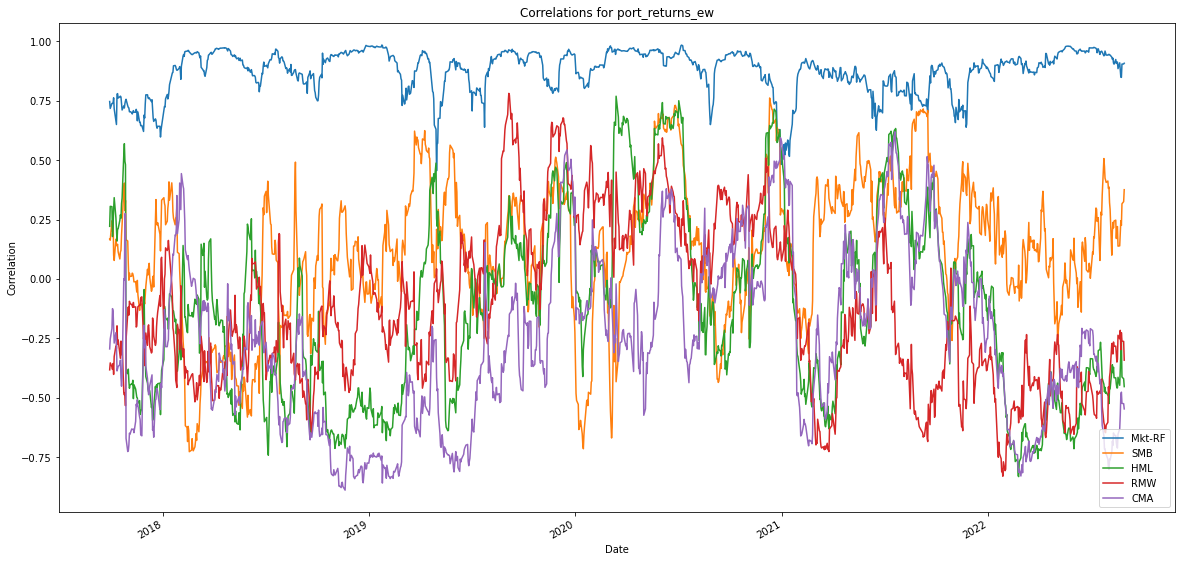

In [18]:
# Call the function portfolio_factor_correlation for the equally weighted portfolio
portfolio_factor_correlation("port_returns_ew", merged_df)

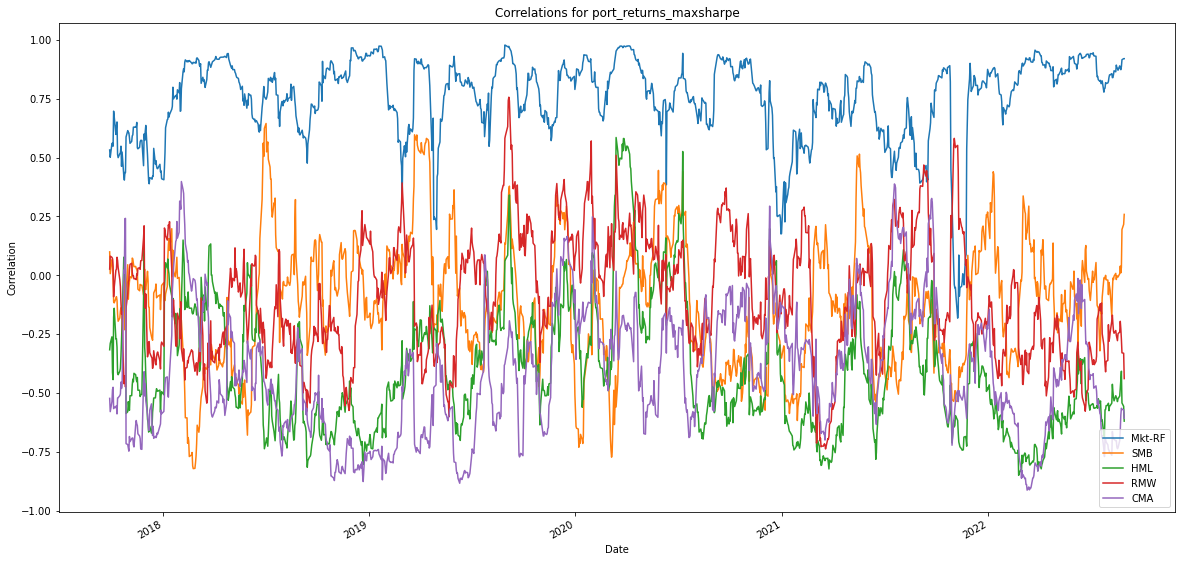

In [19]:
# Call the function portfolio_factor_correlation for the maximum Sharpe portfolio
portfolio_factor_correlation("port_returns_maxsharpe", merged_df)

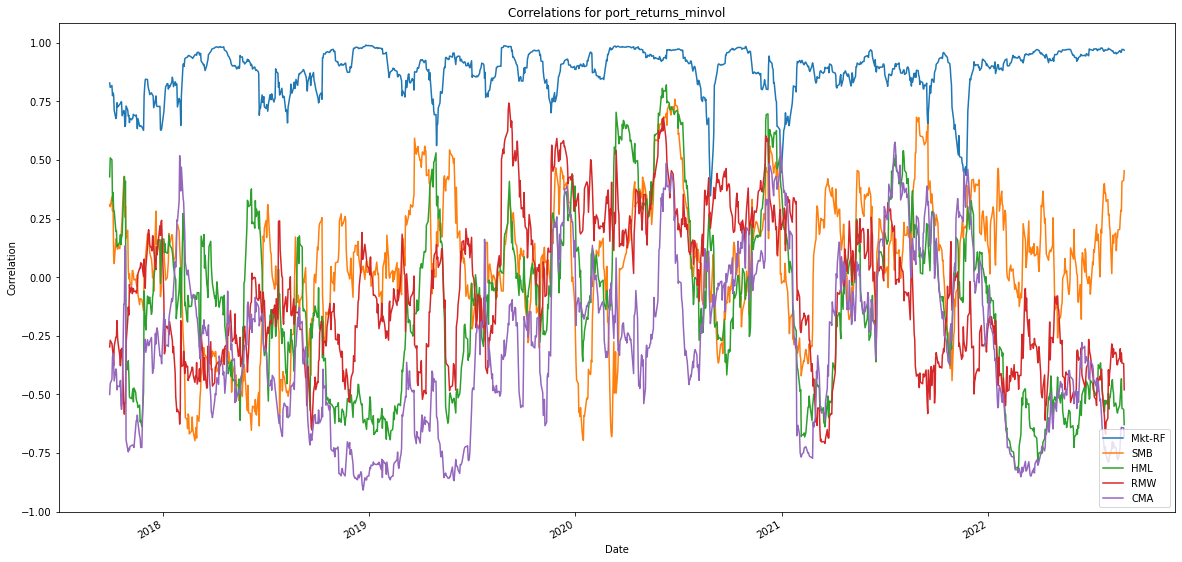

In [20]:
# Call the function portfolio_factor_correlation for the minimum volatility portfolio
portfolio_factor_correlation("port_returns_minvol", merged_df)

All 3 portfolios seem to be very highly correlated to the Mkt-RF. The correlation to the rest of the factors fluctuates significantly.

### 3. Regress the portfolio return on each factor and assess the portfolio's sensitivity to each factor.

#### For the curious, optional challenge, how do you test whether the intercept (i.e., alpha) is significantly different from the risk-free rate for a single-factor regression?

In [21]:
# Import the ols function
import statsmodels.api as sm

# function that takes portfolio and factor returns and run a regression of portfolio return on a factor return
# it reports the portfolio sensitivity to a return factor
def portfolio_factor_sensitivity(portfolio_type, df):
    
    ''' 
    INPUTS
    portfolio type: portfolio_ew, portfolio_maxsharpe, portfolio_minvol
    df: dataframe containing portfolio and factor returns
    
    OUTPUTS
    regression result of a portfolio on a return factor
    
    '''    
    
    print('Sensitivities of ' + portfolio_type + ' returns to individual factors:')
    
    for factor in factors:
        
        # Create the regression model object
        model = sm.OLS(df[portfolio_type], df[factor])
        
        # Fit the model
        model = model.fit()
        
        # Print the parameters of the fitted model
        print(factor + ": " + str(round(model.params[0], 4)))

        # Optional challenge: testing the hypothesis that the intercept is significantly different from the risk-free rate
        # Hint: F-test
        
        
    # Print the Y Intercept
        
    return 

In [22]:
# Call the function portfolio_factor_sensitivity for the equally weighted portfolio
portfolio_factor_sensitivity("port_returns_ew", merged_df)

Sensitivities of port_returns_ew returns to individual factors:
Mkt-RF: 1.137
SMB: 0.3109
HML: -0.0159
RMW: -0.3882
CMA: -0.9624


In [23]:
# Call the function portfolio_factor_sensitivity for the maximum Sharpe portfolio
portfolio_factor_sensitivity("port_returns_maxsharpe", merged_df)

Sensitivities of port_returns_maxsharpe returns to individual factors:
Mkt-RF: 1.1692
SMB: -0.2467
HML: -0.5097
RMW: -0.3135
CMA: -1.4824


In [24]:
# Call the function portfolio_factor_sensitivity for minimum volatility portfolio
portfolio_factor_sensitivity("port_returns_minvol", merged_df)

Sensitivities of port_returns_minvol returns to individual factors:
Mkt-RF: 1.0761
SMB: 0.2128
HML: -0.0187
RMW: -0.2074
CMA: -1.0374


### 4. Regress the portfolio return on all factors and assess the portfolio's sensitivity to factors.

#### For the curious, optional challenge, how do you test whether the intercept (i.e., alpha) is significantly different from the risk-free rate for a multi-factor regression?
#### Hint: Write functions for repetitive lines of codes

In [28]:
# Import the ols function
import statsmodels.api as sm

# function that takes portfolio and factor returns and run a regression of portfolio return on a return factor
# it reports the portfolio sensitivity to a return factor
def portfolio_all_factor_sensitivity(portfolio_type, df):
    
    ''' 
    INPUTS
    portfolio type: portfolio_ew, portfolio_maxsharpe, portfolio_minvol
    df: dataframe containing portfolio and factor returns
    
    OUTPUTS
    regression result of a portfolio on a return factor
    
    '''  
    
    print('Sensitivities of ' + portfolio_type + ' returns to all factors:')

        
    # Create the model object
    model = sm.OLS(df[portfolio_type], df[factors])
    
    # Fit the model
    model = model.fit()

    # Print the parameters of the fitted model
    print(model.params)
    print(model.summary())
    
    # Optional challenge: testing the hypothesis that the intercept is significantly different from the risk-free rate
    # Hint: F-test
    print(model.wald_test(r_matrix = "CMA = 0", use_f=True))

    return 

In [29]:
# Call the function portfolio_all_factor_sensitivity for the equally weighted portfolio
portfolio_all_factor_sensitivity("port_returns_ew", merged_df)

Sensitivities of port_returns_ew returns to all factors:
Mkt-RF    1.113841
SMB      -0.139709
HML       0.193568
RMW      -0.162106
CMA      -0.320365
dtype: float64
                                 OLS Regression Results                                
Dep. Variable:        port_returns_ew   R-squared (uncentered):                   0.856
Model:                            OLS   Adj. R-squared (uncentered):              0.855
Method:                 Least Squares   F-statistic:                              1486.
Date:                Thu, 13 Oct 2022   Prob (F-statistic):                        0.00
Time:                        15:14:38   Log-Likelihood:                          4581.7
No. Observations:                1258   AIC:                                     -9153.
Df Residuals:                    1253   BIC:                                     -9128.
Df Model:                           5                                                  
Covariance Type:            nonrobust    

/Users/lucatriglia/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [ ]:
# Call the function portfolio_all_factor_sensitivity for the maximum Sharpe portfolio
portfolio_all_factor_sensitivity("port_returns_maxsharpe", merged_df)

In [ ]:
# Call the function portfolio_all_factor_sensitivity for the minimum volatility portfolio
portfolio_all_factor_sensitivity("port_returns_minvol", merged_df)

The minimum volatility portfolio seems to be more sensitive to the CMA factor

### 5. Optional Bonus. Construct a multi-factor pricing model for assets based on Arbitrage Pricing Theory.

#### The Arbitrage Pricing Theory (APT) is a theory of asset pricing that holds that an asset’s returns can be forecasted with the linear relationship of an asset’s expected returns and the macroeconomic (e.g., GDP, changes in inflation, yield curve changes, changes in interest rates, market sentiments, exchange rates) or firm-specific statistical factors that affect the asset’s risk. Hint: You can draw these variables straight into your Jupyter notebook via Refinitiv API.

#### The APT is a substitute for the Capital Asset Pricing Model (CAPM) in that both assert a linear relation between assets’ expected returns and their covariance with other random variables. (In the CAPM, the covariance is with the market portfolio’s return.) The covariance is interpreted as a measure of risk that investors cannot avoid by diversification. The slope coefficient in the linear relation between the expected returns and the covariance is interpreted as a risk premium ~ "Arbitrage Pricing Theory (Guberman and Wang 2005).

In [ ]:
#!pip install Eikon

import eikon as ek

ek.set_app_key('8f28279a9d2141a09d1e72c755a9ca34ff7b46b6')

In [ ]:
# Obtain the inflation factor (monthly CPI data) from Refinitiv
inflation_factor = ek.get_timeseries(["USCPNX=ECI"], interval = 'monthly', start_date = start, end_date = end)
# Calculate the percentage Change
inflation_factor = inflation_factor.pct_change()[1:]
inflation_factor.columns = ['CPI']
print(inflation_factor.tail())

In [ ]:
# Obtain the currency factor (EUR/USD) from Refinitiv
currency_factor = ek.get_timeseries(["EUR="], interval = 'monthly', start_date = start, end_date = end)['CLOSE']
# Calculate the percentage Change
currency_factor = currency_factor.pct_change()[1:]
print(currency_factor.head())

In [ ]:
# We use the Risk Free Rate which we imported previously
risk_free = merged_df['RF']
print(risk_free.head())

In [ ]:
# We now concatinate our factors
APT_df = pd.concat([inflation_factor, currency_factor], axis = 1)

# Next we merge with our stock price data (not percentage change yet!)
APT_df = pd.merge(prices, APT_df, left_index=True, right_index=True)

# We then calculate the percentage change for the MONTHLY prices)
monthly_port_returns = portfolio_return_series(APT_df.iloc[:,:len(symbols_list)].pct_change()[1:], equal_weights)
print(monthly_port_returns.tail())

In [ ]:
# We now create our final APT dataframe
APT_df = pd.concat([inflation_factor, currency_factor], axis = 1)
APT_df = pd.merge(monthly_port_returns.to_frame(), APT_df, left_index=True, right_index=True)
APT_df = pd.merge(APT_df, risk_free, left_index=True, right_index=True)
APT_df.columns = ['Port', 'CPI', 'CURR', 'RF']
APT_df.head()

In [ ]:
# We now calculate the excess portfolio returns by subtracting RF
APT_df['Port'] = APT_df['Port'] - APT_df['RF']
APT_df['CPI'] = APT_df['CPI'].astype(float)
APT_df['CURR'] = APT_df['CURR'].astype(float)
APT_df.drop('RF', axis = 1, inplace = True)

# Now we can visualise the correlation
print(APT_df.corr())

Based on the results, there does not apprear to be much of a correlation between my portfolio returns and the CPI index and the exchange rate between USD and EURO

In [ ]:
# Now we can run the model to determine the sensitivity
model = sm.OLS(APT_df['Port'].astype(float), APT_df[['CPI', 'CURR']])

# Fit the model
model = model.fit()

# Print the parameters of the fitted model
print('Sensitivities of portfolio returns to all macro factors:')

print(model.params)

My portfolio seems to be highly sensitive to CPI changes but much less sensitive to the currency exchange between USD and EURO

Acknowledgement: This notebook is inspired by DataCamp course "Introduction to Portfolio Analysis in Python" by Charlotte Werger.